In [178]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [187]:
df = pd.read_csv('../data/unlock-the-box-data.csv', parse_dates=['start_date', 'end_date'])
print(df.dtypes)

start_date       datetime64[ns]
end_date         datetime64[ns]
reasons                  object
gender                   object
ethnicity                object
age                       int64
facility_id               int64
facility_name            object
facility_type            object
dtype: object


In [188]:
rsns = df.reasons.unique().tolist()

In [189]:
strlist = "[a, b]"

def str_to_list(x):
    return x.strip('[]').replace("'", "").split(', ')

#print(str_to_list(strlist))
rsns_unq = np.unique(sum([str_to_list(x) for x in rsns], [])).tolist()
rsns_unq

['COVID-19',
 'Disciplinary sanctions',
 'Inmate is a threat or danger to the safety and security of the facility',
 'Inmate is threat to others',
 'Medical and mental health hold',
 'Other']

In [190]:
rsns_short = ['covid', 'discipline', 'security', 'threat', 'medical', 'other']

for rsn in range(len(rsns_unq)): 
    df[f'rsn_{rsns_short[rsn]}_ind'] = df.reasons.str.contains(rsns_unq[rsn]).replace({True: 1, False: 0})
 
df['duration'] = df.end_date - df.start_date

df.head(5)

,start_date,end_date,reasons,gender,ethnicity,age,facility_id,facility_name,facility_type,rsn_covid_ind,rsn_discipline_ind,rsn_security_ind,rsn_threat_ind,rsn_medical_ind,rsn_other_ind,duration
0,2020-11-29,NaT,['Disciplinary sanctions'],Male,Hispanic,35,18,Metropolitan Detention Center,Jail,0,1,0,0,0,0,NaT
1,2022-03-31,2022-04-04,['Other'],Female,Asian,21,18,Metropolitan Detention Center,Jail,0,0,0,0,0,1,4 days
2,2022-03-31,NaT,['Disciplinary sanctions'],Male,Hispanic,29,18,Metropolitan Detention Center,Jail,0,1,0,0,0,0,NaT
3,2022-03-31,NaT,['Disciplinary sanctions'],Male,Hispanic,33,18,Metropolitan Detention Center,Jail,0,1,0,0,0,0,NaT
4,2022-03-31,NaT,['Other'],Male,Hispanic,60,18,Metropolitan Detention Center,Jail,0,0,0,0,0,1,NaT


In [191]:
df.set_index('start_date', inplace = True)
df = df[df.facility_id == 18]

In [192]:
df.head()
sums = df.groupby([df.index.year, df.index.month]).sum().iloc[:, -6:]
sums.index.rename(['year', 'month'], inplace = True)
sums.reset_index(inplace = True)
sums['day'] = 1
sums['date'] = pd.to_datetime(sums[['year', 'month', 'day']])


df_agg = sums.melt(id_vars = ['year', 'month'])
df_agg['day'] = 1
df_agg.head()

df_agg['date'] = pd.to_datetime(df_agg[['year', 'month', 'day']])

df_agg.drop(['year', 'month', 'day'], axis = 1, inplace = True)

sums = sums[sums.date > "2018"]
dates = sums.date
y = sums.drop(['date', 'year', 'month', 'day'], axis = 1).to_numpy()
y


/var/folders/2x/739ft8655g558m5n5lw8c34c0000gn/T/ipykernel_7606/1076400628.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sums = df.groupby([df.index.year, df.index.month]).sum().iloc[:, -6:]


array([[  0,  29,  12,   0,   0,   9],
       [  0,  27,  14,   3,   0,  23],
       [  0,  43,   7,   4,   0,  23],
       [  0,   0,   2,   0,   0,   0],
       [  0,  57,  16,   0,   1,  72],
       [  0,  69,  27,   0,   0,  66],
       [  0,   4,   1,   0,   0,   5],
       [  0,  27,   0,   0,   0,  53],
       [  0,  19,   8,   0,   0,  38],
       [  0,  57,   2,   0,   0, 224],
       [  0, 200,  44,   0,   4, 172],
       [  0, 176,  48,   0,   0, 160],
       [  0, 192,  34,   0,   0, 174],
       [  0,  69,  19,   0,   0, 247],
       [  0,  76,  20,   0,   0, 118],
       [  0,  66,  19,   0,   2, 149],
       [  0,  80,  10,   0,   0, 130],
       [  0,  81,  20,   0,   0, 160],
       [  0, 111,   4,   0,   0, 112],
       [  0,  46,  12,   0,   0, 154],
       [  0, 100,   8,   0,   0, 142],
       [  0, 254,  26,   0,   2, 260]])

In [181]:
def gaussian_smooth(x, y, sd):
    weights = np.array([stats.norm.pdf(x, m, sd) for m in x])
    weights = weights / weights.sum(1)
    return (weights * y).sum(1)

(array([18140., 18262., 18383., 18506., 18628., 18748., 18871., 18993.]),
 [Text(18140.0, 0, '2019-09'),
  Text(18262.0, 0, '2020-01'),
  Text(18383.0, 0, '2020-05'),
  Text(18506.0, 0, '2020-09'),
  Text(18628.0, 0, '2021-01'),
  Text(18748.0, 0, '2021-05'),
  Text(18871.0, 0, '2021-09'),
  Text(18993.0, 0, '2022-01')])

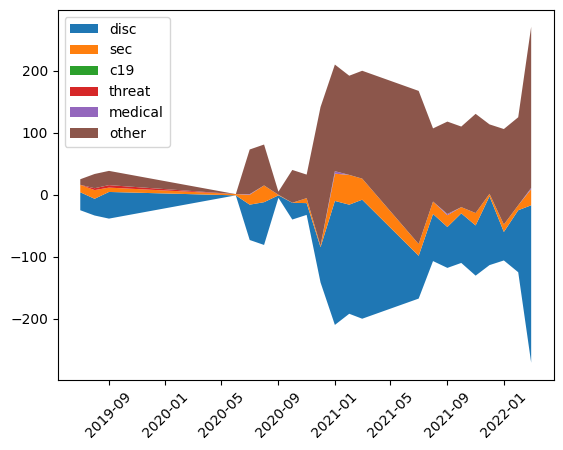

In [193]:
fig, ax = plt.subplots()

#grid = np.linspace(1985, 2025, num=500)
#y_smoothed = [gaussian_smooth(dates, y_, 1) for y_ in y]

#ax.stackplot(dates, y_smoothed, labels = ['disc', 'sec', 'c19', 'threat', 'medical', 'other' ], baseline = 'wiggle')
ax.stackplot(sums.date, sums.rsn_discipline_ind, sums.rsn_security_ind, sums.rsn_covid_ind, sums.rsn_threat_ind, sums.rsn_medical_ind, sums.rsn_other_ind, labels = ['disc', 'sec', 'c19', 'threat', 'medical', 'other' ], baseline = 'sym')
ax.legend(loc='upper left')
plt.xticks(rotation = 45)
